In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
from scipy import pi
from sympy.physics.wigner import clebsch_gordan,wigner_3j,wigner_6j
from sympy import N
from arc import Cesium
tau=2*pi

In [2]:
from basics import *
from rabi_frequencies import *
from atomic_physics import *
from hybrid_matrix_elements import *
from utility import RydStateFS

# Relevant computed constants

## q_rad_int
The result of the radial integral
$$\int_0^{\infty} r^4 R_{6,0}(r) R_{5, 2}(r) $$
Where $R_{n, l}(r)$ is the radial wavefunction for the valence electron in neutral Cesium when it's principle quantum number, and orbital angular momentum quantum number are $n$ and $l$ respectively

This is a numerically computed value available on the wiki. In SI units ($m^2$)

## d_rme_fs
The dipole reduced matrix element between our excited and rydberg states.
$$<5D_{5/2}|| \textbf{e r} ||nP_{3/2}>$$

Numerically computed value available on the wiki. In SI units ($Cm$)

## hf_A and hf_B
A and B hyperfine constants for the $|5D_{5/2}>$ Fine structure level in cesium. From Havey1998. Available on the wiki. 

## DHF
list of hyperfine detunings for the 6D5/2 level, relative to the $fp=6$ HF manifold.
indexed by hyperfine qunatum number $fp$. ie the detuning of the $fp = 4$ level is **DHF\[4\]**

# gamma_e
linewidth of the 5D5/2 state.

In [3]:
print(f"q_rad_int = {q_rad_int/ao**2}a0^2")
print(f"d_rme_fs = {d_rme_fs(52)/ao/e}e a0")
print(f"5D5/2 HF splittings: \n\t" + "\n\t".join([f"f'={fp}': \Delta = 2\pi \\times {DHF[fp]/2/pi*1e-6:.0f} MHz" for fp in range(int(5/2+7/2)+1)]))
print(f"\gamma_e = {gamma_e*1e-3:.0f}kHz")

q_rad_int = 37.5a0^2
d_rme_fs = 0.006400386879521872e a0
5D5/2 HF splittings: 
	f'=0': \Delta = 2\pi \times 0+0j MHz
	f'=1': \Delta = 2\pi \times 425 MHz
	f'=2': \Delta = 2\pi \times 382 MHz
	f'=3': \Delta = 2\pi \times 319 MHz
	f'=4': \Delta = 2\pi \times 234 MHz
	f'=5': \Delta = 2\pi \times 127 MHz
	f'=6': \Delta = 2\pi \times 0 MHz
\gamma_e = 124kHz


# Experiment parameters

In [33]:
p_ge = 100e-3  # W
p_er = 35e-3  # W
w_ge = 14e-6  # m
w_er = 5e-6  # m

phi_ge = 0  # phase on 684nm field
phi_er = 0  # phase of 595nm field

pol_scheme = ["pipi","sigsig","sigx","sigpi","sigpm"][-1]
scheme_lab = {
    "pipi": "$\pi-\pi$",
    "sigsig": "$\sigma-\sigma$",
    "sigx": "$\sigma-X$",
    "sigpi": "$\sigma-\pi$",
    "sigpm": "$\sigma_+_\sigma_-$"
}

if pol_scheme == "sigsig":
    # sigma-sigma polarization scheme
    pol_ge = SphericalVector([0,0,1], spherical_basis=True)  # sigma+ polarized
    pol_er = SphericalVector([0,0,1])  # sigma+ polarized
    k_ar = SphericalVector([1,0,0], spherical_basis=True)  # Z polarized
elif pol_scheme == "pipi":
    # pi-pi polarization scheme
    pol_ge = SphericalVector([1,0,0], spherical_basis=True)  # pi polarized
    pol_er = SphericalVector([1,0,0])  # pi polarized
    k_ar = SphericalVector([1,0,0], spherical_basis=False)  # X polarized
elif pol_scheme == "sigx":
    # sigma-x
    pol_ge = SphericalVector([0,1,0], spherical_basis=True)  # sigma+ polarized
    pol_er = SphericalVector([1,0,0], spherical_basis=False)  # x polarized
    k_ar = SphericalVector([1,0,0], spherical_basis=True)  # Z polarized
elif pol_scheme == "sigpi":
    # sigma-pi
    pol_ge = SphericalVector([0,1,0], spherical_basis=True)  # sigma+ polarized
    pol_er = SphericalVector([1,0,0], spherical_basis=True)  # z polarized
    k_ar = SphericalVector([1,0,0], spherical_basis=True)  # Z polarized
elif pol_scheme == "sigpm":
    # sigma-\pm
    pol_ge = SphericalVector([0,1,0], spherical_basis=True)  # sigma+ polarized
    pol_er = SphericalVector([0,0,1], spherical_basis=True)  # sigma- polarized
    k_ar = SphericalVector([1,0,0], spherical_basis=True)  # Z polarized
    
nr = 52  # Target Rydberg State
fg = 4

bias_B = 5 * gauss # bias field in the z-direction

# Possible laser detunings from unperturbed intermediate states
detuning = np.linspace(DHF[6] - 2*pi*100e6, DHF[1]+tau*100e6, 1000)
#detuning = np.linspace(2*pi*1e7, 2*pi*1e8, 1000)
delta = np.array([detuning - DET for DET in DHF])
swept_param = p_er

## Swept Frequency

In [34]:
O_ge = np.zeros((7,15), dtype=complex)  # ground-to-excited rabi frequencies
O_er = np.zeros((7,15,4), dtype=complex)  # excited-to-rydberg rabi frequencies

z_g = zeeman_g(bias_B)
z_e = np.zeros((7,15), dtype=float)  # zeeman shift on each of the states in the excited manifold
z_r = np.zeros(4, dtype=float)  # zeeman shift on each of the states in the Rydberg manifold

for fp in range(1,7):
    for mp in range(-fp, fp+1):
        O_ge[fp,mp] = q_rabi_frequency(p_ge, w_ge, pol_ge, k_ar, q_rad_int, fp, mp, phi = phi_ge, fg = fg)
        z_e[fp,mp] = zeeman_e(bias_B, fp, mp)
        for i, mr in enumerate(np.arange(-3/2,3/2+1,1)):
            O_er[fp,mp,i] = d_rabi_frequency(p_er, w_er, pol_er, nr, fp, mp, mr, phi = phi_er)
            z_r[i] = zeeman_R(bias_B, nr, mr)


In [35]:
mps = [-1,1]
for i,mr in enumerate(np.arange(-3/2,3/2+1,1)):
    print(f"mr = {int(2*mr)}/2")
    
    for fp in range(1,7)[::-1]:
        print(f"\tf' = {fp}'")
        mf = 1
        O1p = O_ge[fp,mf]/tau*1e-6
        O2p = O_er[fp,mf,i]/tau*1e-6
        mf = -1
        O1m = O_ge[fp,mf]/tau*1e-6
        O2m = O_er[fp,mf,i]/tau*1e-6
        
        print(f"\t\Omega_1+ = {O1p:.2f}MHz")
        print(f"\t\Omega_1- = {O1m:.2f}MHz")

        print(f"\t\Omega_2+ = {O2p:.2f}MHz")
        print(f"\t\Omega_2- = {O2m:.2f}MHz")

        diamond_rabi = O1p*O2p+O1m*O2m
        print(f"\tOd = {diamond_rabi:.1f}MHz^2")

mr = -3/2
	f' = 6'
	\Omega_1+ = 0.00+0.00jMHz
	\Omega_1- = 0.00-17.71jMHz
	\Omega_2+ = -4.46+0.00jMHz
	\Omega_2- = -5.76+0.00jMHz
	Od = 0.0+102.0jMHz^2
	f' = 5'
	\Omega_1+ = 0.00+0.00jMHz
	\Omega_1- = 0.00-11.75jMHz
	\Omega_2+ = 4.65+0.00jMHz
	\Omega_2- = 0.55+0.00jMHz
	Od = 0.0-6.4jMHz^2
	f' = 4'
	\Omega_1+ = 0.00+0.00jMHz
	\Omega_1- = 0.00+2.79jMHz
	\Omega_2+ = -0.16+0.00jMHz
	\Omega_2- = 4.23+0.00jMHz
	Od = 0.0+11.8jMHz^2
	f' = 3'
	\Omega_1+ = 0.00+0.00jMHz
	\Omega_1- = 0.00+7.85jMHz
	\Omega_2+ = -3.95+0.00jMHz
	\Omega_2- = -1.02+0.00jMHz
	Od = -0.0-8.0jMHz^2
	f' = 2'
	\Omega_1+ = 0.00+0.00jMHz
	\Omega_1- = 0.00+3.36jMHz
	\Omega_2+ = 2.11+0.00jMHz
	\Omega_2- = -3.82+0.00jMHz
	Od = 0.0-12.8jMHz^2
	f' = 1'
	\Omega_1+ = 0.00+0.00jMHz
	\Omega_1- = 0.00+0.00jMHz
	\Omega_2+ = 3.66+0.00jMHz
	\Omega_2- = 2.84+0.00jMHz
	Od = 0.0+0.0jMHz^2
mr = -1/2
	f' = 6'
	\Omega_1+ = 0.00+0.00jMHz
	\Omega_1- = 0.00-17.71jMHz
	\Omega_2+ = -9.98+0.00jMHz
	\Omega_2- = -7.73+0.00jMHz
	Od = 0.0+136.9jMHz^2
	f'

In [36]:
rabi = np.zeros((4, len(detuning)), dtype = complex)
AC_stark = np.zeros((4, len(detuning)), dtype = complex)
p_scatter = np.zeros((4, len(detuning)), dtype = complex)

for i, mr in enumerate(np.arange(-3/2,3/2+1,1)):
    for fp in range(1,7):
        for mp in range(-fp, fp+1):
            d = delta[fp]-z_e[fp,mp]
            if fp == 6:
                #print(f"g to |{fp},{mp}> to |{mr}>")
                #print(f"\t{d[0]*1e-6/tau} - {d[-1]*1e-6/tau} Mhz")
                #print(f"\tOmega_ge({fp},{mp}) = {O_ge[fp,mp]*1e-6/tau:.2f} MHz")
                #print(f"\tOmega_er({fp},{mp}|mr={mr}) = {O_er[fp,mp,i]*1e-6/tau:.2f} MHz")
                con = (O_ge[fp,mp]*O_er[fp,mp,i])/(2)
                #print(f"\tRabi Contribution = {con*1e-12/tau} MHz^2")
            rabi[i] += (O_ge[fp,mp]*O_er[fp,mp,i])/(2 * d)
            AC_stark[i] += (O_ge[fp,mp]*O_ge[fp,mp].conjugate() - O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(4 * d)
            p_scatter[i] += gamma_e * (O_ge[fp,mp]*O_ge[fp,mp].conjugate() + O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(2 * d)**2
    t_pi = pi/np.absolute(rabi[i])
    p_scatter[i] *= t_pi

<IPython.core.display.Javascript object>


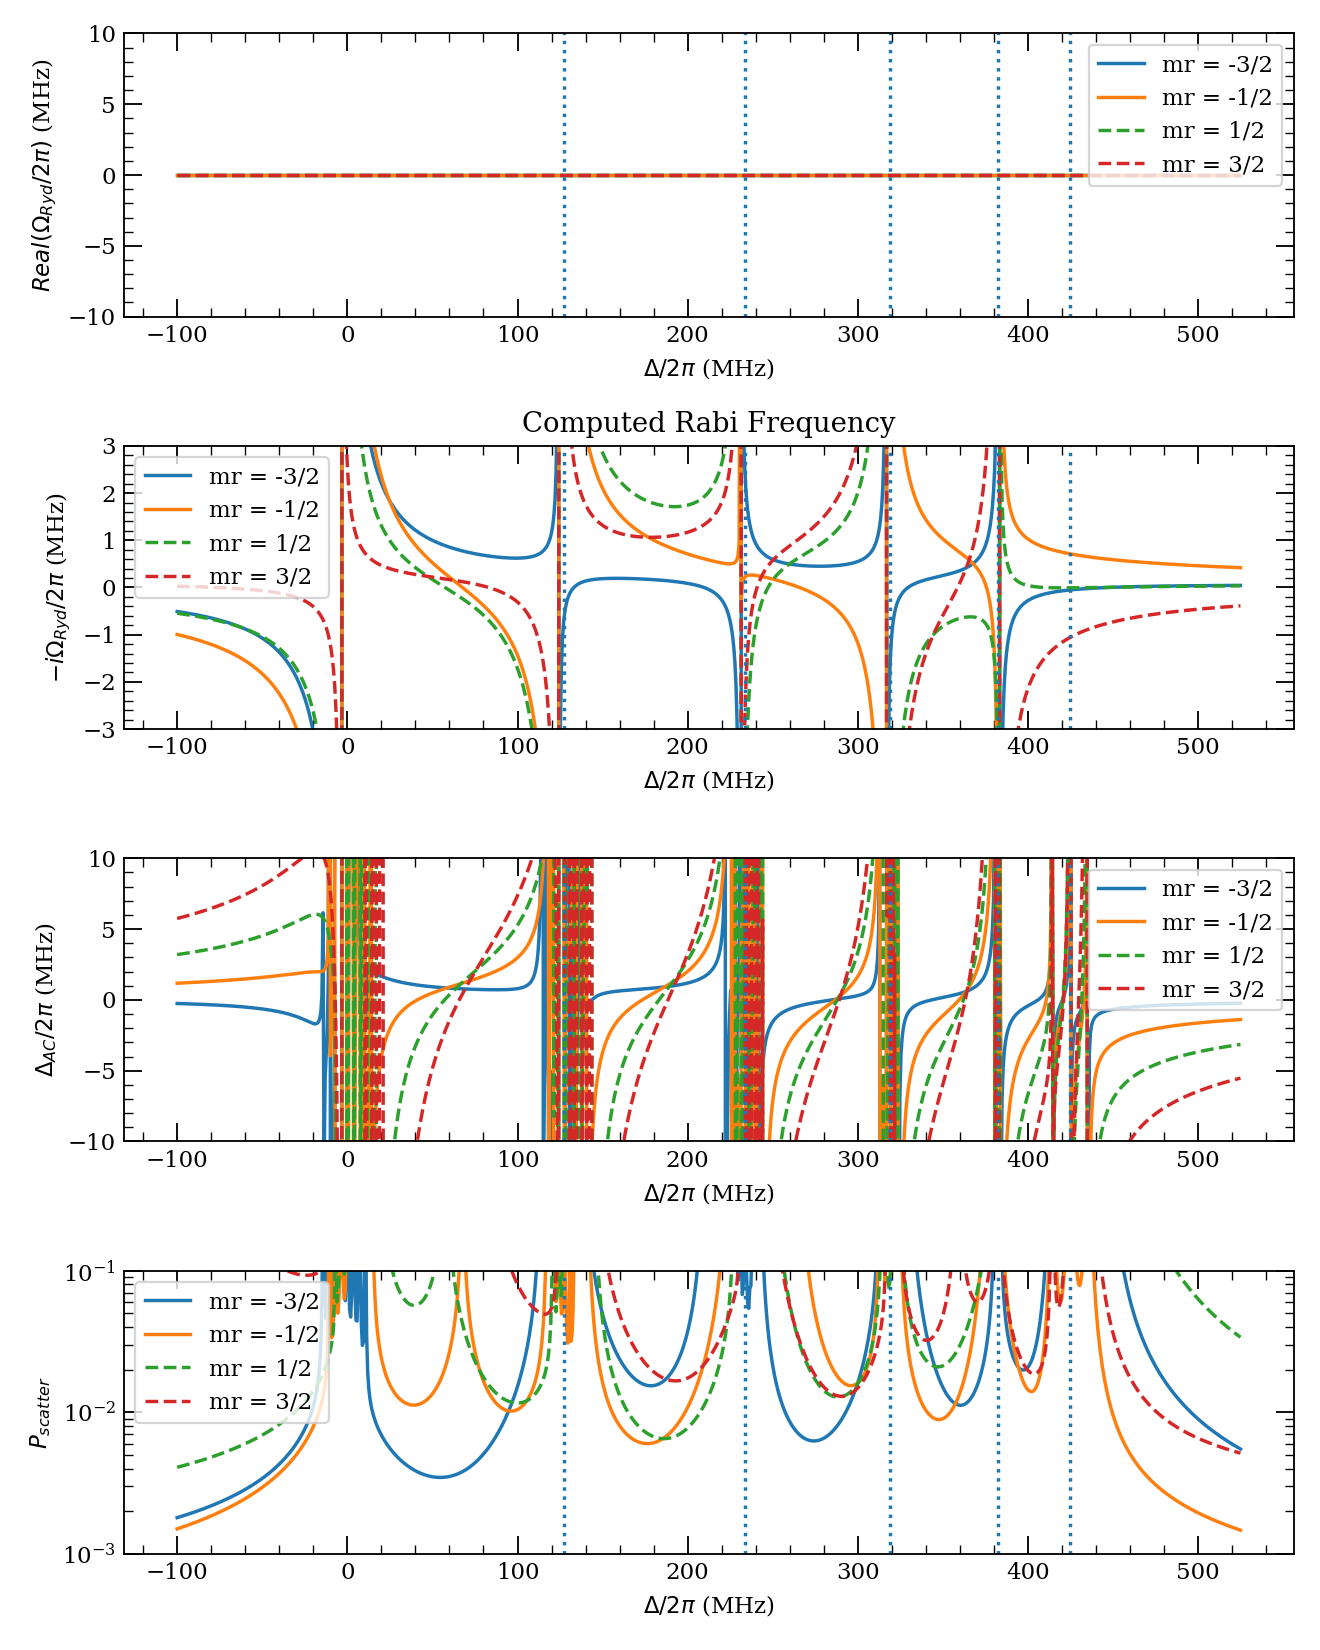

In [37]:
fig, axar = plt.subplots(4,1,figsize = (8,10))
ln = ['-','-','--','--']
for i, mr in enumerate(np.arange(-3/2,3/2+1)):
    plt_det = detuning * 1e-6 / (2 * pi)
    #rabi_r = rabi.real
    axar[0].plot(plt_det, rabi[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[0].set_ylim(-10,10)
    axar[0].set_ylabel("$Real(\Omega_{Ryd}/2\pi)$ (MHz)")
    axar[0].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[0].legend()
    
    axar[1].plot(plt_det, rabi[i,:].imag*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[1].set_ylim(-3,3)
    axar[1].set_ylabel("$-i\Omega_{Ryd}/2\pi$ (MHz)")
    axar[1].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[1].set_title("Computed Rabi Frequency")
    #axar[1].axvline(80,ls=":",c="k")
    axar[1].legend()
    
    axar[2].plot(plt_det, AC_stark[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[2].set_ylim(-10,10)
    axar[2].set_ylabel("$\Delta_{AC}/2\pi$ (MHz)")
    axar[2].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[2].legend()
    
    axar[3].plot(plt_det, abs(p_scatter[i,:]), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[3].set_ylim(1e-3,1e-1)
    axar[3].set_ylabel("$P_{scatter}$")
    axar[3].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[3].legend()
    axar[3].set_yscale("log")
    
for ax in axar:
    for fp in range(1,6):
        ax.axvline(DHF[fp]/tau*1e-6,ls=":")
#    ax.set_title(f"mr = {mr*2:.0f}/2")

fig.tight_layout()
fig.show()
fig.savefig("RabiEstimates.png")

<IPython.core.display.Javascript object>


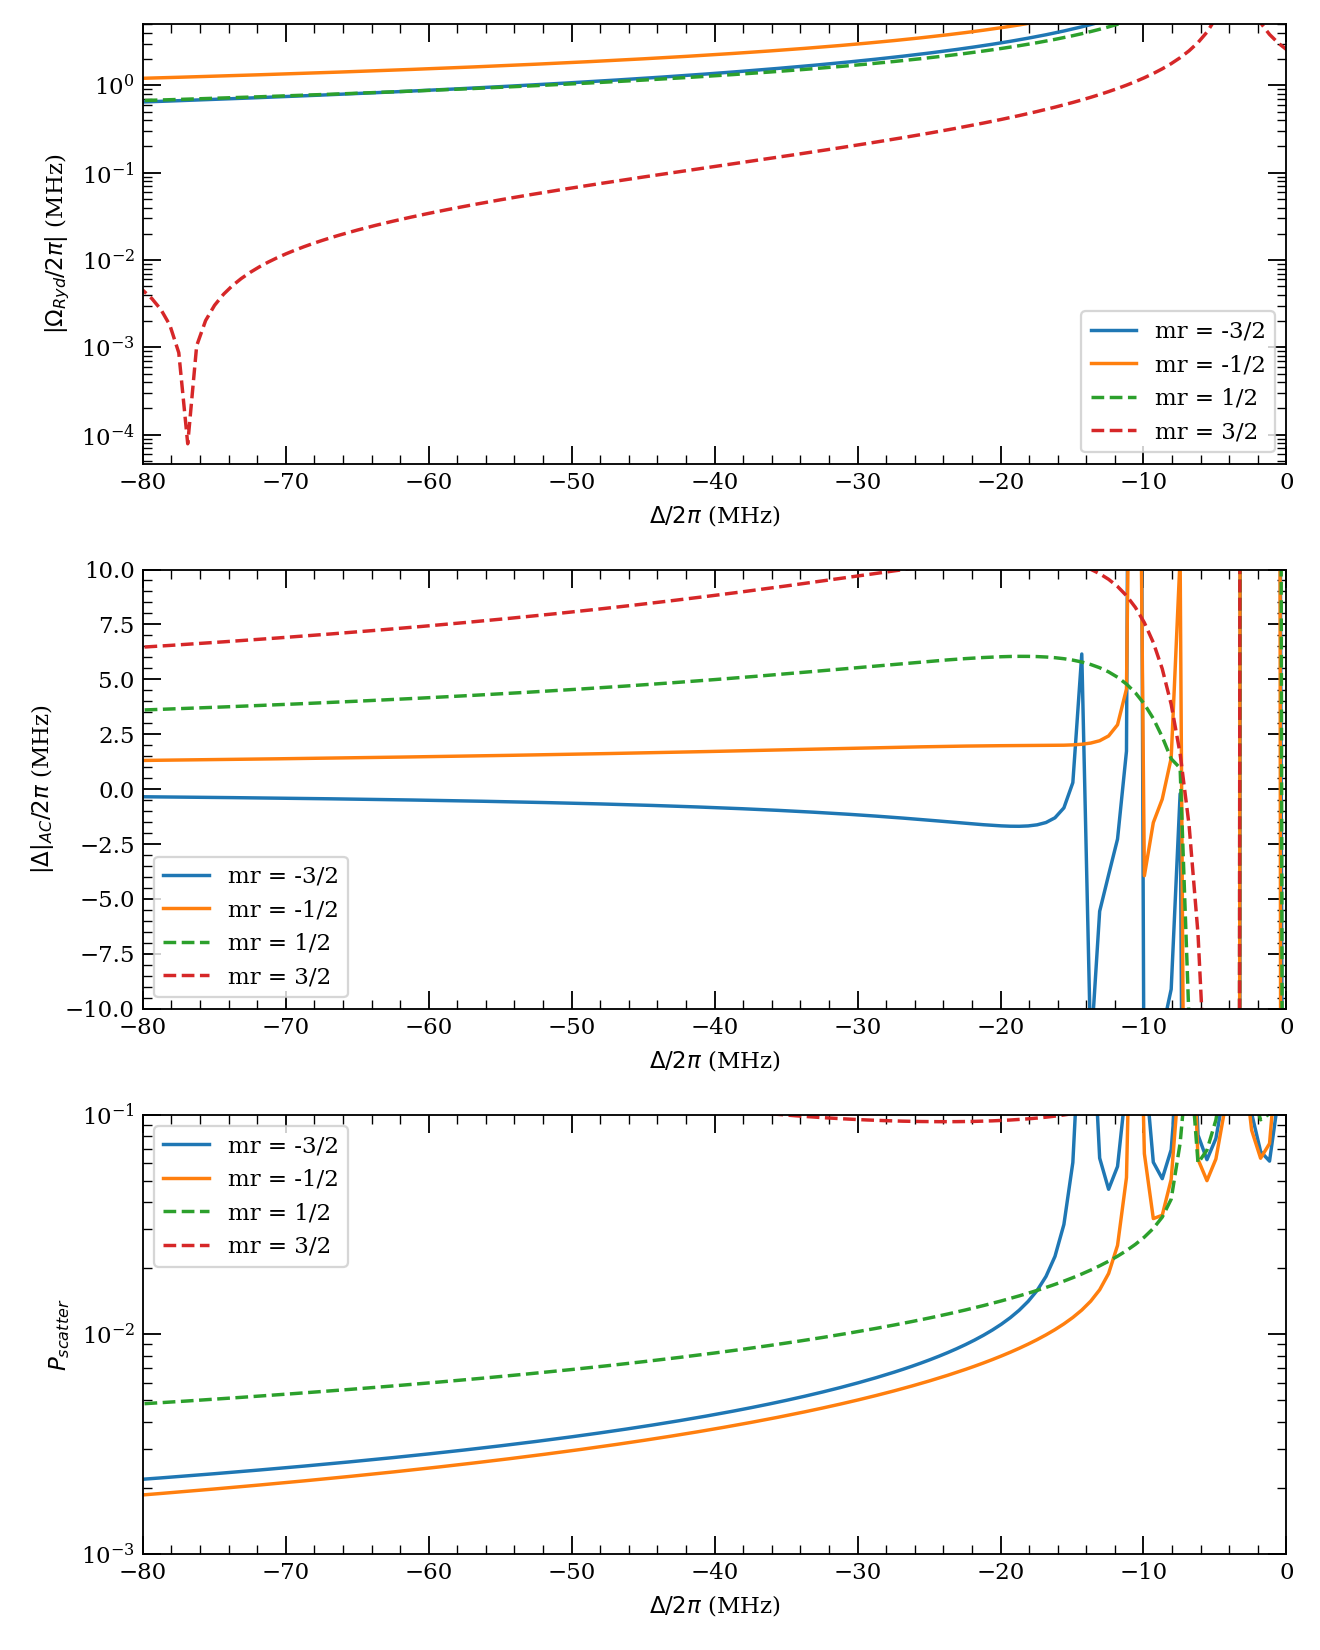

<ipython-input-38-a1809741a0fd>:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axar[0].set_ylim(0,5)
<ipython-input-38-a1809741a0fd>:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axar[0].set_ylim(0,5)
<ipython-input-38-a1809741a0fd>:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axar[0].set_ylim(0,5)


In [38]:
fig, axar = plt.subplots(3,1,figsize = (8,10))
ln = ['-','-','--','--']

#xlim = [0,120]
xlim = [-80,0]
#xlim = [0,100]
xlab = "$\Delta/2\pi$ (MHz)"

for i, mr in enumerate(np.arange(-3/2,3/2+1)):
    plt_det = (detuning) * 1e-6 / (2 * pi)
    #rabi_r = rabi.real
    axar[0].plot(plt_det, np.abs(rabi[i,:])*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[0].set_ylim(0,5)
    axar[0].set_xlim(*xlim)
    axar[0].set_ylabel("$|\Omega_{Ryd}/2\pi|$ (MHz)")
    axar[0].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[0].set_yscale("log")
    axar[0].legend()
    
    axar[1].plot(plt_det, AC_stark[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[1].set_ylim(-10,10)
    axar[1].set_xlim(*xlim)
    axar[1].set_ylabel("$|\Delta|_{AC}/2\pi$ (MHz)")
    axar[1].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[1].legend()
    
    axar[2].plot(plt_det, abs(p_scatter[i,:]), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[2].set_ylim(1e-3,1e-1)
    axar[2].set_xlim(*xlim)
    axar[2].set_ylabel("$P_{scatter}$")
    axar[2].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[2].legend()
    axar[2].set_yscale("log")
#    ax.set_title(f"mr = {mr*2:.0f}/2")

fig.tight_layout()
fig.show()
fig.savefig("rabi_blue_sigx_from3.png")

In [39]:
lim_det = np.where((2*pi*xlim[0]*1e6 < detuning)*(detuning < 2*pi*1e6*xlim[1]))[0]
AC_starkP = AC_stark[:,lim_det]
P_scatP = p_scatter[:,lim_det]
rabiP = rabi[:,lim_det]

no_stark_ind = np.where(np.abs(AC_starkP[2]) == min(np.abs(AC_starkP[2])))
min_p_ind = np.where(P_scatP[3] == min(P_scatP[3]))
opt_ind = min_p_ind
# opt_ind = no_stark_ind
print(f"detuning that provides minimal scattering probability = 2 pi x {detuning[lim_det][opt_ind][0]*1e-6/(2*pi):.2f}MHz")
for i,mr in enumerate(np.arange(-3/2,5/2)):
    print(f"mr = {int(2*mr)}/2")
    print(f"\trabi frequency : 2 pi x {abs(rabiP[i][opt_ind][0]/(2*pi)*1e-6):.2f}MHz")
    print(f"\tAC stark shift : 2 pi x {abs(AC_starkP[i][opt_ind][0]/(2*pi)*1e-6):.2f}MHz")
    print(f"\tScattering probability : {abs(P_scatP[i][opt_ind][0]):.5f}")

detuning that provides minimal scattering probability = 2 pi x -23.70MHz
mr = -3/2
	rabi frequency : 2 pi x 2.50MHz
	AC stark shift : 2 pi x 1.48MHz
	Scattering probability : 0.00825
mr = -1/2
	rabi frequency : 2 pi x 3.80MHz
	AC stark shift : 2 pi x 1.95MHz
	Scattering probability : 0.00651
mr = 1/2
	rabi frequency : 2 pi x 2.19MHz
	AC stark shift : 2 pi x 5.89MHz
	Scattering probability : 0.01237
mr = 3/2
	rabi frequency : 2 pi x 0.31MHz
	AC stark shift : 2 pi x 10.25MHz
	Scattering probability : 0.09289


In [40]:
lim_det = np.where((2*pi*xlim[0]*1e6 < detuning)*(detuning < 2*pi*1e6*xlim[1]))[0]
AC_starkP = AC_stark[:,lim_det]
P_scatP = p_scatter[:,lim_det]
rabiP = rabi[:,lim_det]


In [41]:
red_ind = np.argwhere((detuning-(DHF[6]-tau*80e6)) > 0).T[0][0]
mid_ind = np.argwhere((detuning-(DHF[6]+tau*80e6)) > 0).T[0][0]

rOt = rabi[:,red_ind]
mOt = rabi[:,mid_ind]
rDt = AC_stark[:,red_ind]
mDt = AC_stark[:,mid_ind]
rErr = p_scatter[:,red_ind]
mErr = p_scatter[:,mid_ind]

for i, mr in enumerate(np.arange(-3/2,5/2)):
    print(f"mr = {int(2*mr)}/2\nfor detuning -80MHz")
    print(f"\t \Omega_r = {rOt[i]/tau*1e-6:.2f}MHz")
    print(f"\t \Delta_{{AC}} = {rDt[i]/tau*1e-6:.2f}MHz")
    print(f"\t P_s = {rErr[i]:.1e}")

    print(f"for detuning +80MHz")
    print(f"\t \Omega_r = {mOt[i]/tau*1e-6:.2f}MHz")
    print(f"\t \Delta_{{AC}} = {mDt[i]/tau*1e-6:.2f}MHz")
    print(f"\t P_s = {mErr[i]:.1e}")

mr = -3/2
for detuning -80MHz
	 \Omega_r = 0.00-0.65jMHz
	 \Delta_{AC} = -0.35+0.00jMHz
	 P_s = 2.2e-03+0.0e+00j
for detuning +80MHz
	 \Omega_r = 0.00+0.68jMHz
	 \Delta_{AC} = 0.73+0.00jMHz
	 P_s = 5.1e-03+0.0e+00j
mr = -1/2
for detuning -80MHz
	 \Omega_r = 0.00-1.21jMHz
	 \Delta_{AC} = 1.31+0.00jMHz
	 P_s = 1.9e-03+0.0e+00j
for detuning +80MHz
	 \Omega_r = 0.00-0.39jMHz
	 \Delta_{AC} = 1.68+0.00jMHz
	 P_s = 1.6e-02+0.0e+00j
mr = 1/2
for detuning -80MHz
	 \Omega_r = 0.00-0.67jMHz
	 \Delta_{AC} = 3.60+0.00jMHz
	 P_s = 4.8e-03+0.0e+00j
for detuning +80MHz
	 \Omega_r = 0.00-0.59jMHz
	 \Delta_{AC} = 2.57+0.00jMHz
	 P_s = 1.8e-02+0.0e+00j
mr = 3/2
for detuning -80MHz
	 \Omega_r = 0.00+0.00jMHz
	 \Delta_{AC} = 6.47+0.00jMHz
	 P_s = 9.6e-01+0.0e+00j
for detuning +80MHz
	 \Omega_r = 0.00+0.03jMHz
	 \Delta_{AC} = 3.01+0.00jMHz
	 P_s = 5.5e-01+0.0e+00j


In [32]:
detuning[red_ind]/tau*1e-6

-79.98609506888721

## Other swept Parameters

In [43]:
p_ge = 88e-3  # W
p_er = 51e-3 # 52e-3  # W
w_ge = 15e-6  # m
w_er = 5e-6  # m
angles = np.linspace(0,2*pi,300)
pol_ge = (lambda theta: SphericalVector([0,np.sin(theta),np.cos(theta)]))(3.9)  # Z-Y polarized, angle theta from Z
pol_er = lambda theta: SphericalVector([0,np.sin(theta),np.cos(theta)]) # Z-Y polarized, angle theta from Z
k_ar = SphericalVector([1,0,0], spherical_basis=False)  # X polarized
nr = 60  # Target Rydberg State
phi_ge = 0  # phase on 684nm field
phi_er = 0  # phase of 595nm field

bias_B = 5.8 * gauss # bias field in the z-direction

# Possible laser detunings from unperturbed intermediate states
detuning = 2*pi*80e6 #  np.linspace(min(DHF[1:]) - 0.501e9, max(DHF[1:]) + 0.5e9, 1000)
#detuning = np.linspace(2*pi*1e7, 2*pi*1e8, 1000)
swept_param = angles
delta = np.array([detuning - DET for DET in DHF])

In [44]:
O_ge = np.zeros((7,15,len(swept_param)), dtype=complex)  # ground-to-excited rabi frequencies
O_er = np.zeros((7,15,4,len(swept_param)), dtype=complex)  # excited-to-rydberg rabi frequencies

z_g = zeeman_g(bias_B)
z_e = np.zeros((7,15), dtype=float)  # zeeman shift on each of the states in the excited manifold
z_r = np.zeros(4, dtype=float)  # zeeman shift on each of the states in the Rydberg manifold

for fp in range(1,7):
    for mp in range(-fp, fp+1):
        O_ge[fp,mp,:] = q_rabi_frequency(p_ge, w_ge, pol_ge, k_ar, q_rad_int, fp, mp, phi = phi_ge)
        z_e[fp,mp] = zeeman_e(bias_B, fp, mp)
        for i, mr in enumerate(np.arange(-3/2,3/2+1,1)):
            O_er[fp,mp,i,:] = np.array([d_rabi_frequency(p_er, w_er, pol_er(th), nr, fp, mp, mr, phi = phi_er) for th in angles])
            z_r[i] = zeeman_R(bias_B, nr, mr)


In [45]:
rabi = np.zeros((4, len(swept_param)), dtype = complex)
AC_stark = np.zeros((4, len(swept_param)), dtype = complex)
p_scatter = np.zeros((4, len(swept_param)), dtype = complex)

for i, mr in enumerate(np.arange(-3/2,3/2+1,1)):
    for fp in range(1,7):
        for mp in range(-fp, fp+1):
            d = delta[fp]-z_e[fp,mp]
            rabi[i] += (O_ge[fp,mp]*O_er[fp,mp,i])/(2 * d)
            AC_stark[i] += (O_ge[fp,mp]*O_ge[fp,mp].conjugate() - O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(4 * d)
            p_scatter[i] += gamma_e * (O_ge[fp,mp]*O_ge[fp,mp].conjugate() + O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(2 * d)**2
    t_pi = pi/np.absolute(rabi[i])
    p_scatter[i] *= t_pi

<IPython.core.display.Javascript object>


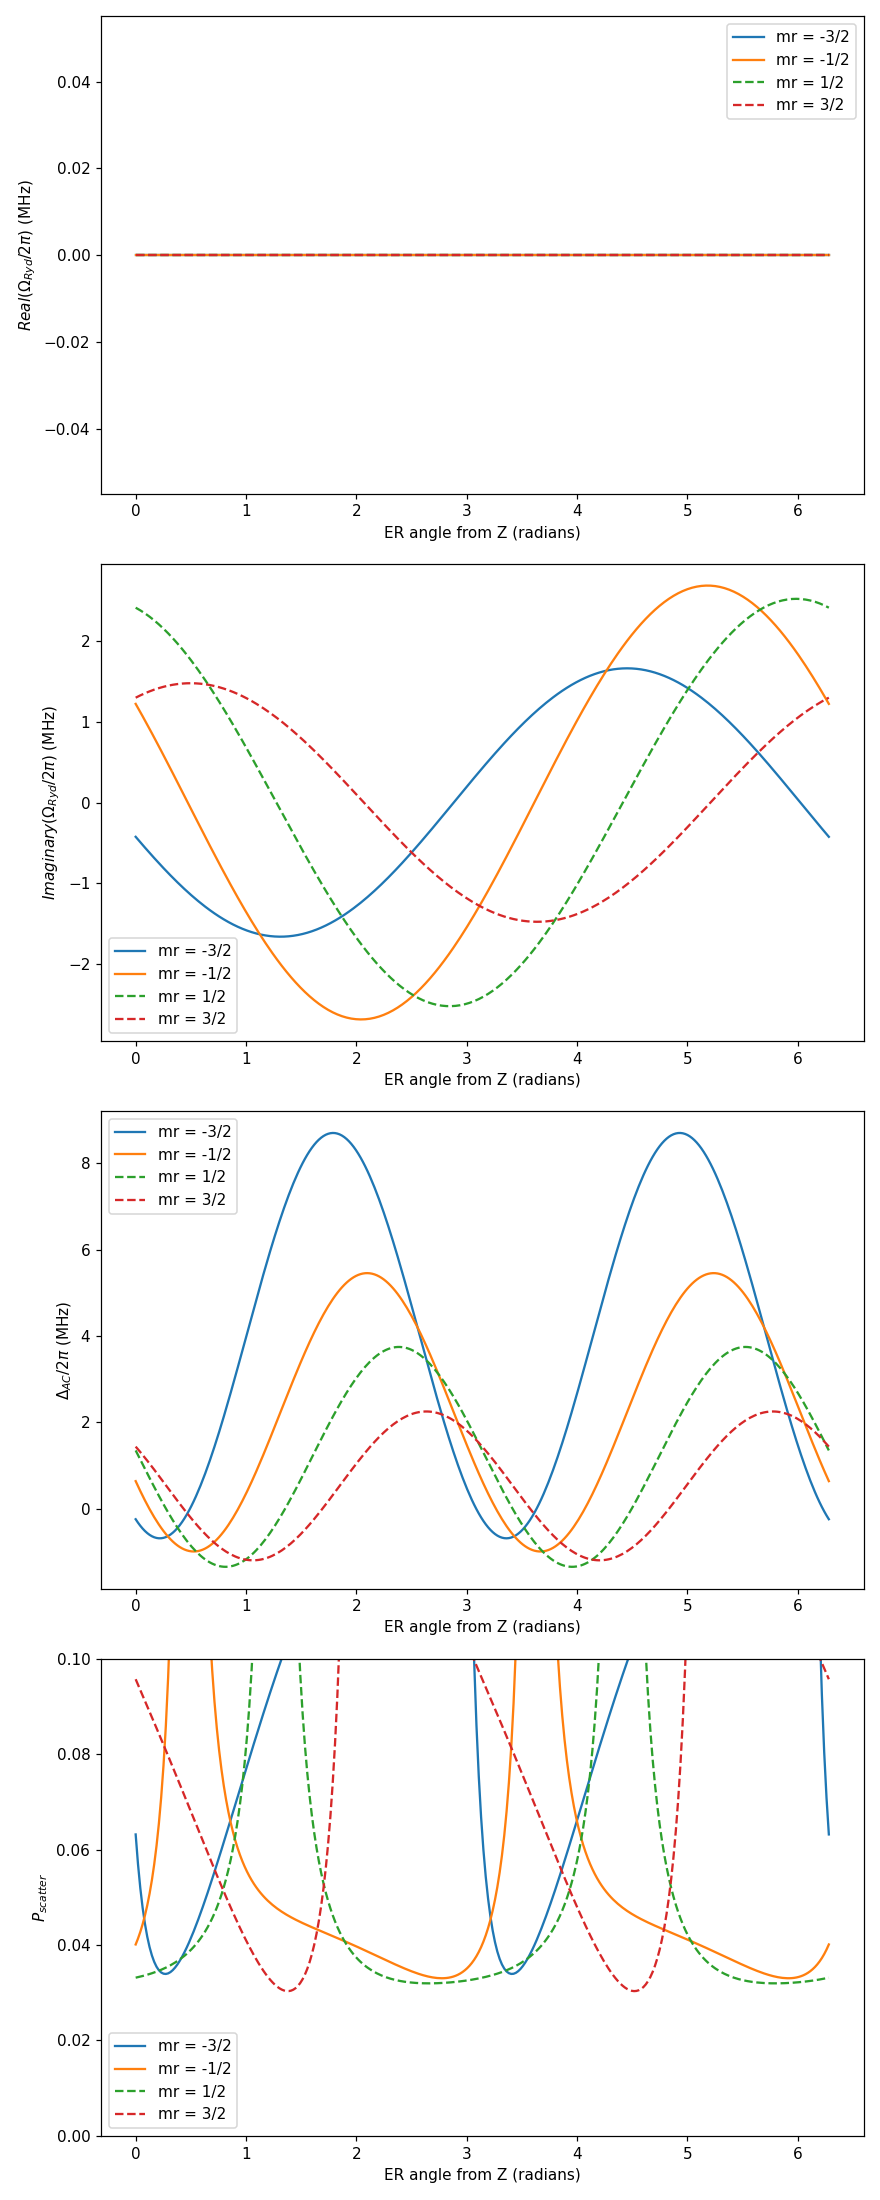

In [46]:
fig, axar = plt.subplots(4,1,figsize = (8,20))
ln = ['-','-','--','--']
for i, mr in enumerate(np.arange(-3/2,3/2+1)):
    plt_det = detuning * 1e-6 / (2 * pi)
    xlab = "ER angle from Z (radians)"
    #rabi_r = rabi.real
    axar[0].plot(swept_param, rabi[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    # axar[0].set_ylim(-3,3)
    axar[0].set_ylabel("$Real(\Omega_{Ryd}/2\pi)$ (MHz)")
    axar[0].set_xlabel(xlab)
    axar[0].legend()
    
    axar[1].plot(swept_param, rabi[i,:].imag*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    #axar[1].set_ylim(-1.75,1.75)
    axar[1].set_ylabel("$Imaginary(\Omega_{Ryd}/2\pi)$ (MHz)")
    axar[1].set_xlabel(xlab)
    axar[1].legend()
    
    axar[2].plot(swept_param, AC_stark[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    #axar[2].set_ylim(0,5)
    axar[2].set_ylabel("$\Delta_{AC}/2\pi$ (MHz)")
    axar[2].set_xlabel(xlab)
    axar[2].legend()
    
    axar[3].plot(swept_param, abs(p_scatter[i,:]), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[3].set_ylim(0,0.1)
    axar[3].set_ylabel("$P_{scatter}$")
    axar[3].set_xlabel(xlab)
    axar[3].legend()
#    ax.set_title(f"mr = {mr*2:.0f}/2")

fig.tight_layout()
fig.show()
fig.savefig("RabiEstimates.png")

# Haphazard LaTeX on the General Zeeman Matrix Elements

## Computing the Matrix element between FS states
Given a magnetic field $\vec{B}$, the perturbing Hamiltonian is:
$$H_B = \frac{\mu_b}{\hbar} \textbf{B} \cdot (g_s \hat{\textbf{S}} + g_l \hat{\textbf{L}})$$

Choosing states $|\alpha, l, j, m_j>$ and $|\alpha, l, j', m_j'>$
We can write the matrix element as
$$<\alpha, l, j', m_j'| H_B |\alpha, l, j, m_j>  = \frac{\mu_b}{\hbar} \sum_{q = -1}^1 (-1)^q B_q <\alpha, l, j', m_j'| g_s \hat{S}_{-q} + g_l \hat{L}_{-q} |\alpha, l, j, m_j>  $$

We can then expand our FS states into separated spin and orbit states:
$$|\alpha, l, j, m_j> = \sum_{m_l,m_s} |\alpha, l, 1/2; m_l, m_s> <\alpha, l, 1/2; m_l, m_s |\alpha, l, j, m_j> $$
$$|\alpha, l, j, m_j> = \sum_{m_l,m_s} |\alpha, l, 1/2; m_l, m_s> C_{l,m_l,1/2,m_s}^{j,m_j} $$

We can then rewrite our sum as
$$<\alpha, l, j', m_j'| H_B |\alpha, l, j, m_j>  = \frac{\mu_b}{\hbar} \sum_{q = -1}^1 (-1)^q B_q \sum_{m_l,m_l',m_s,m_s'} C_{l,ml',1/2,ms'}^{j',m_j'} C_{l,ml,1/2,ms}^{j,m_j} \left(\delta_{m_l,m_l'} g_s <1/2,m_s'|\hat{S}_{-q}|1/2,m_s> + \delta_{m_s,m_s'} g_l <l,ml'|\hat{L}_{-q}|l,ml>\right)$$

We can rewrite those matrix elements using the Wigner-Eckart theorem.
$$ <1/2,m_s'|\hat{S}_{-q}|1/2,m_s> = \frac{<1/2||\hat{S}||1/2>}{\sqrt{2 \frac{1}{2}+1}}C_{1,-q,1/2,m_s}^{1/2,m_s'} $$

We can find the general form of a reduced matrix element of an angular momentum operator (given the total angular momentum quantum numbers are the same) by computing
$$ <j,j|\hat{J}_0|j,j> = \hbar j = \frac{<j||\hat{J}||j>}{\sqrt{2j+1}}C_{1,0,j,j}^{j,j} $$
where $C_{1,0,j,j}^{j,j} = \sqrt{\frac{j}{j+1}}$
thus
$$ <j||\hat{J}||j> = \hbar\sqrt{j(j+1)(2j+1)} $$

We can use the above to rewrite the whole matrix element as
$$<\alpha, l, j', m_j'| H_B |\alpha, l, j, m_j>  = \mu_b \sum_{q = -1}^1 (-1)^q B_q \sum_{m_l,m_l',m_s,m_s'} C_{l,ml',1/2,ms'}^{j',m_j'} C_{l,ml,1/2,ms}^{j,m_j}\left(\delta_{ml,ml'}g_s \frac{\sqrt{3}}{2}C_{1,-q,1/2,ms}^{1/2,ms'} + \delta_{ms,ms'} g_l \sqrt{l (l+1)} C_{1, -q, l, ml}^{l,m_l'}\right)$$

In the code we switch the $q$ and $-q$ above to save space in the long clebsch gordan coefficients. 

## Computing the matrix elements between HF states
Considering the nuclear interaction our hamiltonian is
$$H_B = \frac{\mu_b}{\hbar} \textbf{B} \cdot (g_s \hat{\textbf{S}} + g_l \hat{\textbf{L}} + g_I \hat{\textbf{I}})$$

Choosing states $|\alpha, l, j, f, m_f>$ and $|\alpha, l, j', f', m_f'>$
We can write the matrix element as
$$<\alpha, l, j', f', m_f'| H_B |\alpha, l, j, f, m_f>  = \frac{\mu_b}{\hbar} \sum_{q = -1}^1 (-1)^q B_q <\alpha, l, j', f', m_f'| g_s \hat{S}_{-q} + g_l \hat{L}_{-q} + g_I \hat{I}_{-q}|\alpha, l, j, f, m_f>  $$

And similarly begin decomposing it into the hyperfine basis to arrive at  
$<\alpha, l, j', f', m_f'| H_B |\alpha, l, j, f, m_f>$
$$ = \frac{\mu_b}{\hbar} \sum_{q = -1}^1 (-1)^q B_q \sum_{m_j,m_j',m_I,m_I'}C_{j',m_j',I,m_I'}^{f',m_f'}C_{j,m_j,I,m_I}^{f,m_f} \left(\hbar \delta_{m_j,m_j'} g_I \sqrt{I(I+1)}C_{1,-q,I,m_I}^{I,m_I'} + \delta_{m_I,m_I'} <\alpha, l, j', m_j'|g_s\hat{S}_{-q} + g_l \hat{L}_{-q}||\alpha, l, j, m_j>\right) $$
  
In this implementation as above we flip $q$ and $-q$ for convenience
  
In the code, that lower matrix element is equivalent to the FS matrix element when $\textbf{B} = (-1)^q\textbf{e}_{q}\frac{\hbar}{\mu_b}$. So we compute it with the following line:  
- **(-1)\*\*q * zeeman_fs(1, SphericalVector(qar), lo, j, mj, jp, mjp)/mub**  
    - where **qar** is a length 3 list where all entries are 0, except index **-q**
    - The $\hbar$ is missing because we've canceled it with the leading $\frac{1}{\hbar}$

# Using ARC to compute matrix elements

In [8]:
step = 0.001
il = cs.alphaC**(1/3.0)
ol = lambda n: 2.0*n*(n+15)
eV_per_Hartree = 27.2114

nr = 52
# states of interest (n,l,j)
states = [
    RydStateFS(6,0,1/2),
    RydStateFS(5,2,5/2),
    RydStateFS(nr,1,3/2)
]
energies = np.zeros(len(states))
psis = np.zeros(len(states))

for state in states:
    n,l,j = state.n,state.l,state.j
    E_eV = state.get_energy()  # in eV
    E_au = E_eV/eV_per_Hartree  # in Hartree

    psi = cs.radialWavefunction(l,1/2,j,E_au,il,ol(n),step)
    
    state.quantum_numbers().update({"r":psi[0]})
    state.quantum_numbers().update({"rRho(r)":psi[1]})

<IPython.core.display.Javascript object>


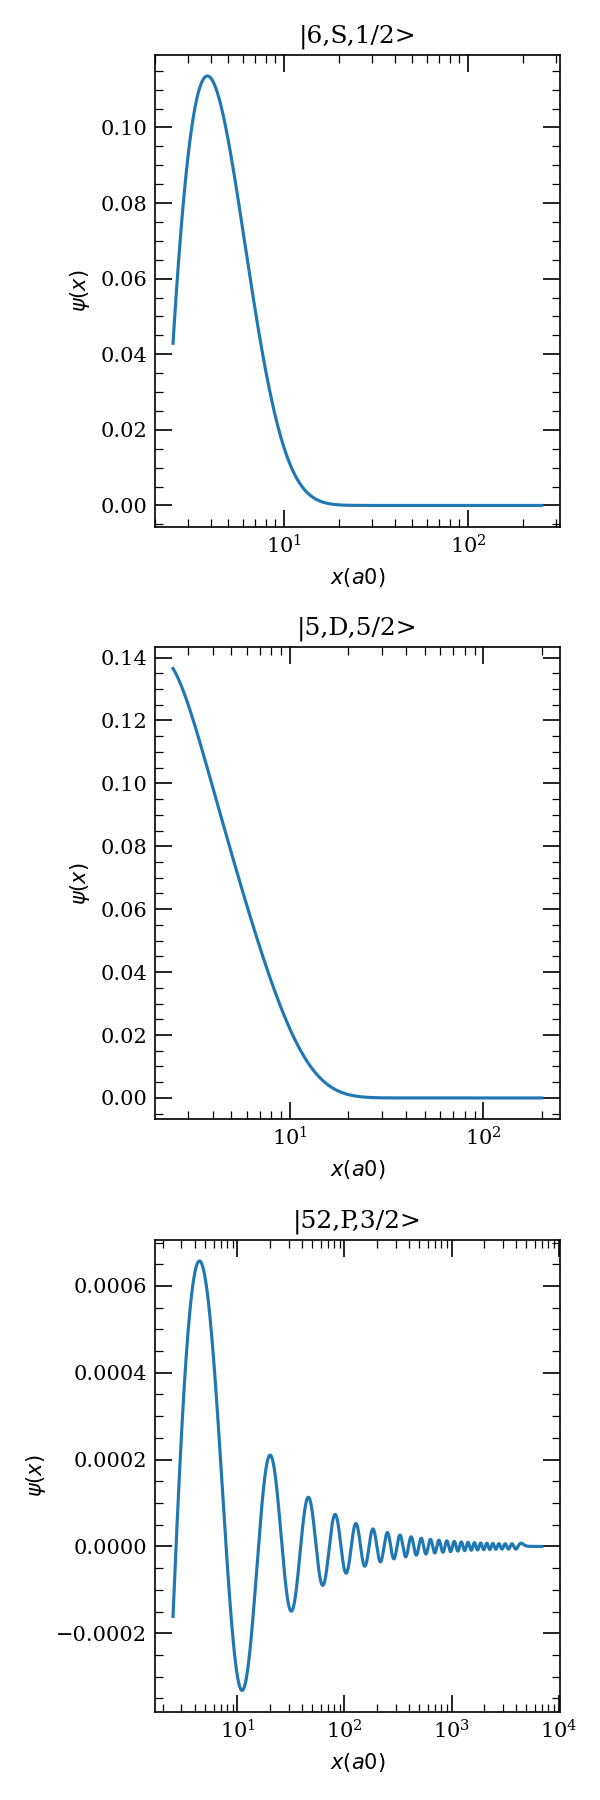

1.0000000000000004
1.0000000000000002
0.9999999999999999


In [18]:
fig,axar=plt.subplots(3,1,figsize=(4,12))

for i,state in enumerate(states):
    ax=axar[i]
    r = state["r"]
    rRho = state["rRho(r)"]
    ax.plot(r,rRho/r)
    ax.set_ylabel("$\psi(x)$")
    ax.set_xlabel("$x (a0)$")
    ax.set_xscale("log")
    ax.set_title(state.ket(bare=True))
    print(np.trapz(rRho**2,r))
fig.tight_layout()
fig.show()

In [24]:
rg = states[0]["r"]
rRhog = states[0]["rRho(r)"]
rq = states[1]["r"]
rRhoq = states[1]["rRho(r)"]

upto = min(len(rg),len(rq))
np.trapz(rRhog[:upto]*rRhoq[:upto]*rg[:upto]**2,rg[:upto])

40.46332061909278

In [26]:
q_rad_int_ARC = cs.getQuadrupoleMatrixElement(6,0,1/2,5,2,5/2)
q_rad_int_ARC

40.46216696428365

In [30]:
q_rad_int/ao**2

37.5

In [4]:
jRME_fs = d_rme_fs(90)/ao/e

In [5]:
import arc
cs = arc.Cesium()
arcRME_fs = cs.getReducedMatrixElementJ(5,2,5/2,90,1,3/2)

In [6]:
for n in range(40,90,5):
    jRME_fs = d_rme_fs(n)/ao/e
    arcRME_fs = cs.getReducedMatrixElementL(5,2,3/2,n,1,1/2)
    print(f"n = {n}")
    print(f"\tJuan's = {jRME_fs}ea0")
    print(f"\tARC's = {arcRME_fs}ea0")
    print(f"\tRatio = {jRME_fs/arcRME_fs}")

n = 40
	Juan's = 0.009486832980505134ea0
	ARC's = -0.011862320774057338ea0
	Ratio = -0.7997451056333471
n = 45
	Juan's = 0.00795046391999925ea0
	ARC's = 0.009754339140015873ea0
	Ratio = 0.8150694584099023
n = 50
	Juan's = 0.006788225099390855ea0
	ARC's = -0.008206611337352593ea0
	Ratio = -0.8271654182639406
n = 55
	Juan's = 0.005883926072406474ea0
	ARC's = 0.007030218622664119ea0
	Ratio = 0.8369478089113459
n = 60
	Juan's = 0.005163977794943222ea0
	ARC's = -0.006111102069165488ea0
	Ratio = -0.8450157985412928
n = 65
	Juan's = 0.004579744046370772ea0
	ARC's = 0.00537668632979005ea0
	Ratio = 0.8517781706915387
n = 70
	Juan's = 0.004097926660575063ea0
	ARC's = -0.0047787930819516745ea0
	Ratio = -0.8575233516705136
n = 75
	Juan's = 0.0036950417228136046ea0
	ARC's = 0.004284301771746083ea0
	Ratio = 0.8624606574591679
n = 80
	Juan's = 0.003354101966249684ea0
	ARC's = -0.003869764889389318ea0
	Ratio = -0.8667456711508357
n = 85
	Juan's = 0.0030625476397927926ea0
	ARC's = 0.0035181621555854282

In [ ]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
from scipy import pi
from sympy.physics.wigner import clebsch_gordan,wigner_3j,wigner_6j
from sympy import N

In [ ]:
from basics import *
from rabi_frequencies import *
from atomic_physics import *

In [ ]:
F = 4
Fp = 3
B = 1 * gauss
mfs = np.arange(-F,F+1,1)
mfps = np.arange(-Fp,Fp+1,1)
zeeman = np.zeros((len(mfs),len(mfs)),dtype=float)
for mf in mfs:
    for mfp in mfps:
        zeeman[mf,mfp] = zeeman_me_hf(B,SphericalVector([1,0,0]),0,1/2,F,mf,1/2,Fp,mfp)

In [ ]:
print("\n".join([
    ",  ".join([f"{zeeman[mf,mfp]*1e-6/h:.2f}" for mf in mfs])
for mfp in mfps]))

<IPython.core.display.Javascript object>


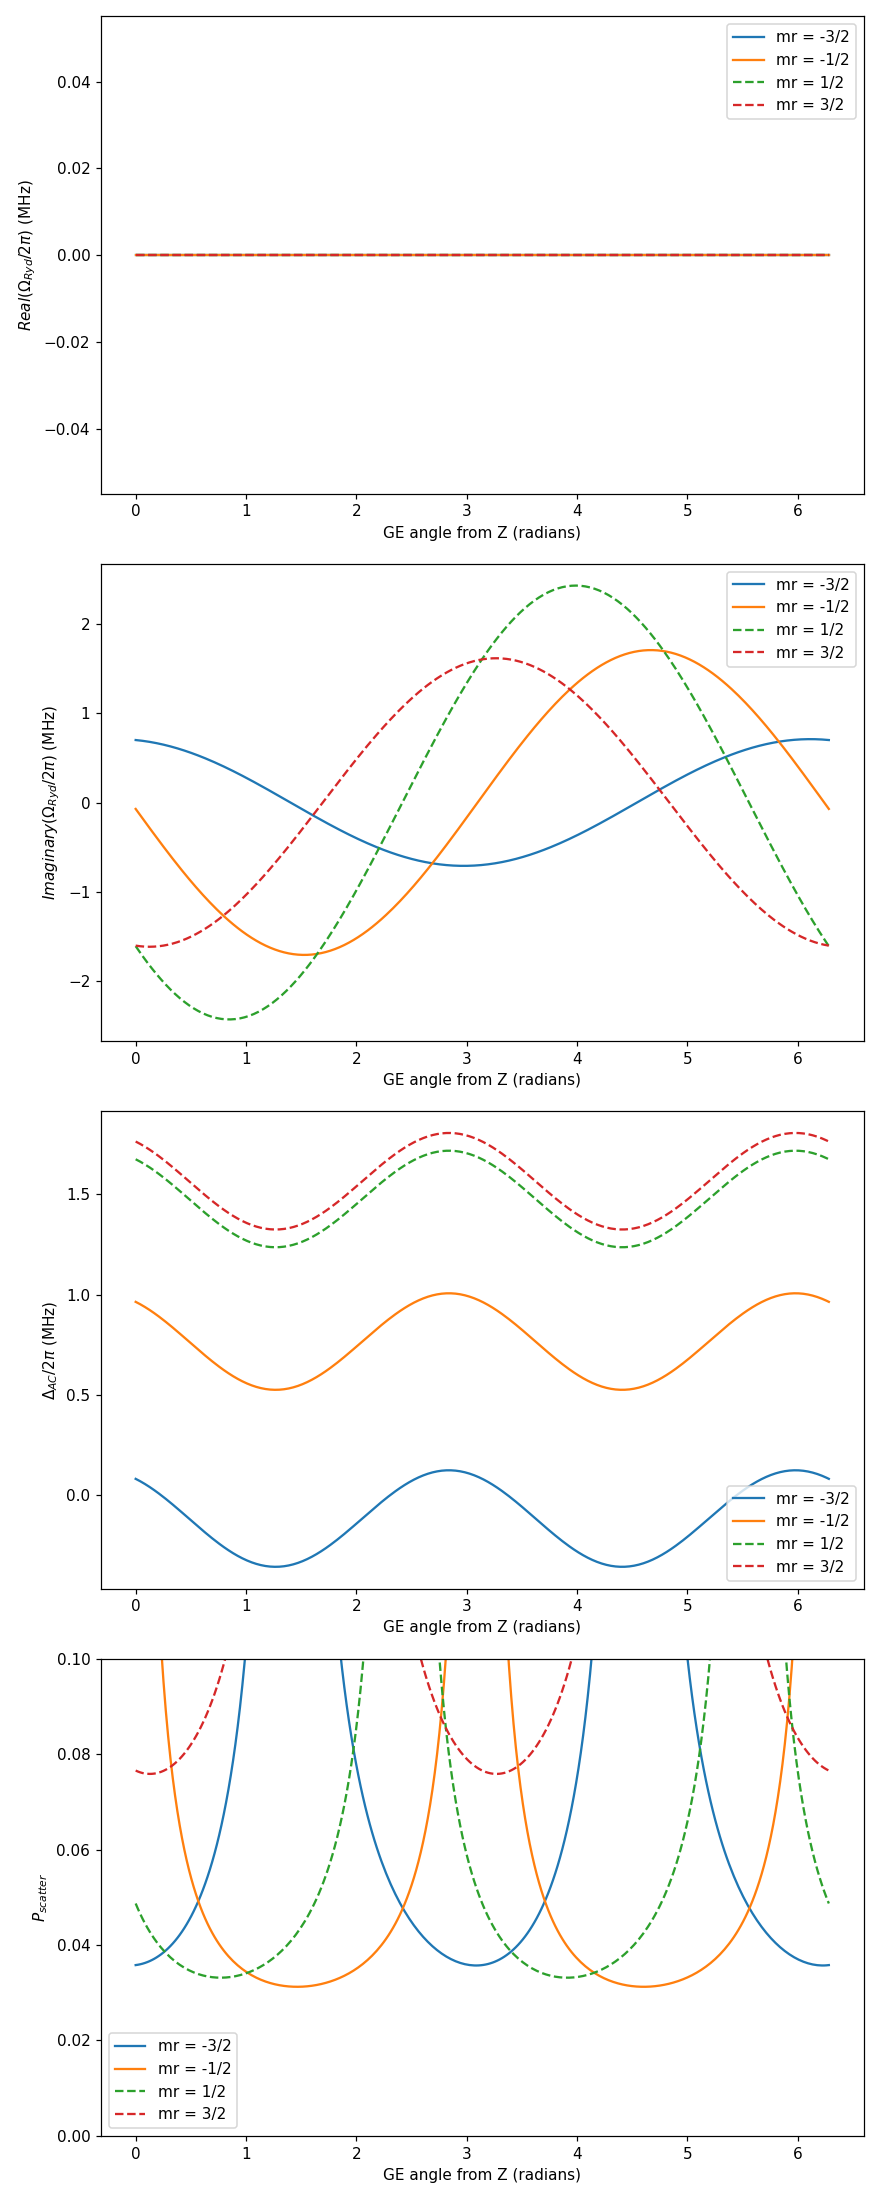

In [34]:
fig, axar = plt.subplots(4,1,figsize = (8,20))
ln = ['-','-','--','--']
for i, mr in enumerate(np.arange(-3/2,3/2+1)):
    plt_det = detuning * 1e-6 / (2 * pi)
    xlab = "GE angle from Z (radians)"
    #rabi_r = rabi.real
    axar[0].plot(swept_param, rabi[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    # axar[0].set_ylim(-3,3)
    axar[0].set_ylabel("$Real(\Omega_{Ryd}/2\pi)$ (MHz)")
    axar[0].set_xlabel(xlab)
    axar[0].legend()
    
    axar[1].plot(swept_param, rabi[i,:].imag*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    #axar[1].set_ylim(-1.75,1.75)
    axar[1].set_ylabel("$Imaginary(\Omega_{Ryd}/2\pi)$ (MHz)")
    axar[1].set_xlabel(xlab)
    axar[1].legend()
    
    axar[2].plot(swept_param, AC_stark[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    #axar[2].set_ylim(0,5)
    axar[2].set_ylabel("$\Delta_{AC}/2\pi$ (MHz)")
    axar[2].set_xlabel(xlab)
    axar[2].legend()
    
    axar[3].plot(swept_param, abs(p_scatter[i,:]), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[3].set_ylim(0,0.1)
    axar[3].set_ylabel("$P_{scatter}$")
    axar[3].set_xlabel(xlab)
    axar[3].legend()
#    ax.set_title(f"mr = {mr*2:.0f}/2")

fig.tight_layout()
fig.show()
fig.savefig("RabiEstimates.png")